In [ ]:
from langsmith import Client
from langchain_community.llms import OpenAI
from langsmith import traceable
from langchain_community.vectorstores import Pinecone
from pinecone import Pinecone
from typing_extensions import Annotated, TypedDict
import os
import pinecone
from langsmith.evaluation import evaluate
from langchain.evaluation import CriteriaEvalChain
from langchain_openai import ChatOpenAI
from rag_system import ask_question
from vector_store import query_vector_store, format_context
from langsmith.schemas import Run, Example

client = Client()

/Users/lama/Desktop/ChefBot/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [102]:

# Define the examples for the dataset
examples = [
{
        "inputs":{
            "question": "what is the ingredient for the recipe?",
            "video_id": "F6wb4VJdrKM",
        },
        "output": {
            "answer": "18 oz raspberries, 1 tablespoon lemon juice, 1/3 cup or 66g granulated sugar, 1 tablespoon of water, 2 tablespoons of cornstarch, 1 and 1/2 cups (180g) of graham cracker crumbs, 1/4 cup or 50g granulated sugar, 7 tablespoons of unsalted butter, 3 (8 oz blocks) of cream cheese, 200g granulated sugar, 1/2 cup of sour cream, 1/4 teaspoon of salt, 2 teaspoons vanilla, 3 large eggs."
        }
    },
    {
        "inputs": {
            "question": "what is the ingredient for the recipe?",
            "video_id": "KLtECtW-96w",          
        },
        "output": {
            "answer": "3 pounds of apples, 2 rounds of pastry, 2 tablespoons of lemon juice, 1 cup of sugar (200g), 1/2 cup of flour, 1/2 teaspoon of nutmeg, 1 and 1/2 teaspoons of cinnamon, 2 tablespoons of butter, 1 egg"
        }
    },
    {
        "inputs": {
            "question": "How long and at what temperature should I bake the pie?",
            "video_id": "KLtECtW-96w",        
        },
        "output": {
            "answer": "425 Fahrenheit for 20 minutes, reduce to 375 Fahrenheit and bake until golden brown, about 50 minutes"
        }
    },
]


# Create the dataset
dataset_name = "recipe_qa_dataset_v3"
dataset = client.create_dataset(dataset_name=dataset_name)

# Create the examples
client.create_examples(
    dataset_id=dataset.id,
    examples=examples
)


{'example_ids': ['9185ca0c-3038-4765-8fe3-6c4cbc37b3d0',
  '6cbe7087-30b1-4aca-b5bf-68e5ff12e074',
  '15502530-8800-4a35-b16d-db5f4dd22d31'],
 'count': 3}

In [ ]:
def load_llm():
    return ChatOpenAI(
        model_name="gpt-3.5-turbo",
        temperature=0.7,
        openai_api_key=os.getenv("OPENAI_API_KEY")
    )

# Define the target function
def target(inputs: dict) -> dict:
    question = inputs["question"]
    video_id = inputs["video_id"]
    llm = load_llm()
    # Initialize Pinecone
    from pinecone import Pinecone
    pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"), environment="us-east-1")
    index_name = "audios-transcripts"

    response = ask_question(
        question=question,
        video_id=video_id,
        llm=llm,
        pc=pc,
        index_name=index_name
    )
    return {"answer": response}

In [144]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
llm = ChatOpenAI(model_name="gpt-4", temperature=0.7, openai_api_key=os.getenv("OPENAI_API_KEY"))

def is_answered(run: Run, example: Example) -> dict:
    # Get outputs
    student_answer = run.outputs.get("answer")

    # Check if the student_answer is empty
    if not student_answer:
        return {"key": "is_answered", "score": 0}

    # Use LLM to verify the answer quality
    prompt = f"""You're evaluating whether the following answer is a meaningful attempt or not.

    Question: {example.inputs.get("question")}
    Answer: {student_answer}

    Does this answer appear to be a real attempt at answering the question? Reply with "yes" or "no".
    """

    response = llm([HumanMessage(content=prompt)]).content.lower().strip()

    if "yes" in response:
        return {"key": "is_answered", "score": 1}
    else:
        return {"key": "is_answered", "score": 0}
    

qa_evalulator = [is_answered]


dataset_name = "recipe_qa_dataset_v3"

experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evalulator,  # Pass as a list
    experiment_prefix="test-recipe-qa-eval-is-answered-llm-gpt-4",
    # Any experiment metadata can be specified here
    metadata={
        "variant": "context into gpt-4",
  
    }
)

/var/folders/ck/mhktfb696vqc0jwr3cy7htm00000gn/T/ipykernel_64888/2644010371.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4", temperature=0.7, openai_api_key=os.getenv("OPENAI_API_KEY"))


View the evaluation results for experiment: 'test-recipe-qa-eval-is-answered-llm-gpt-4-c38e2a91' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=bbe3c53b-de18-4ad6-8f6c-4be738f2d24f




0it [00:00, ?it/s]/var/folders/ck/mhktfb696vqc0jwr3cy7htm00000gn/T/ipykernel_64888/2644010371.py:22: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=prompt)]).content.lower().strip()
3it [00:21,  7.19s/it]


![Screenshot 1446-11-06 at 23.55.11.png](<attachment:Screenshot 1446-11-06 at 23.55.11.png>)
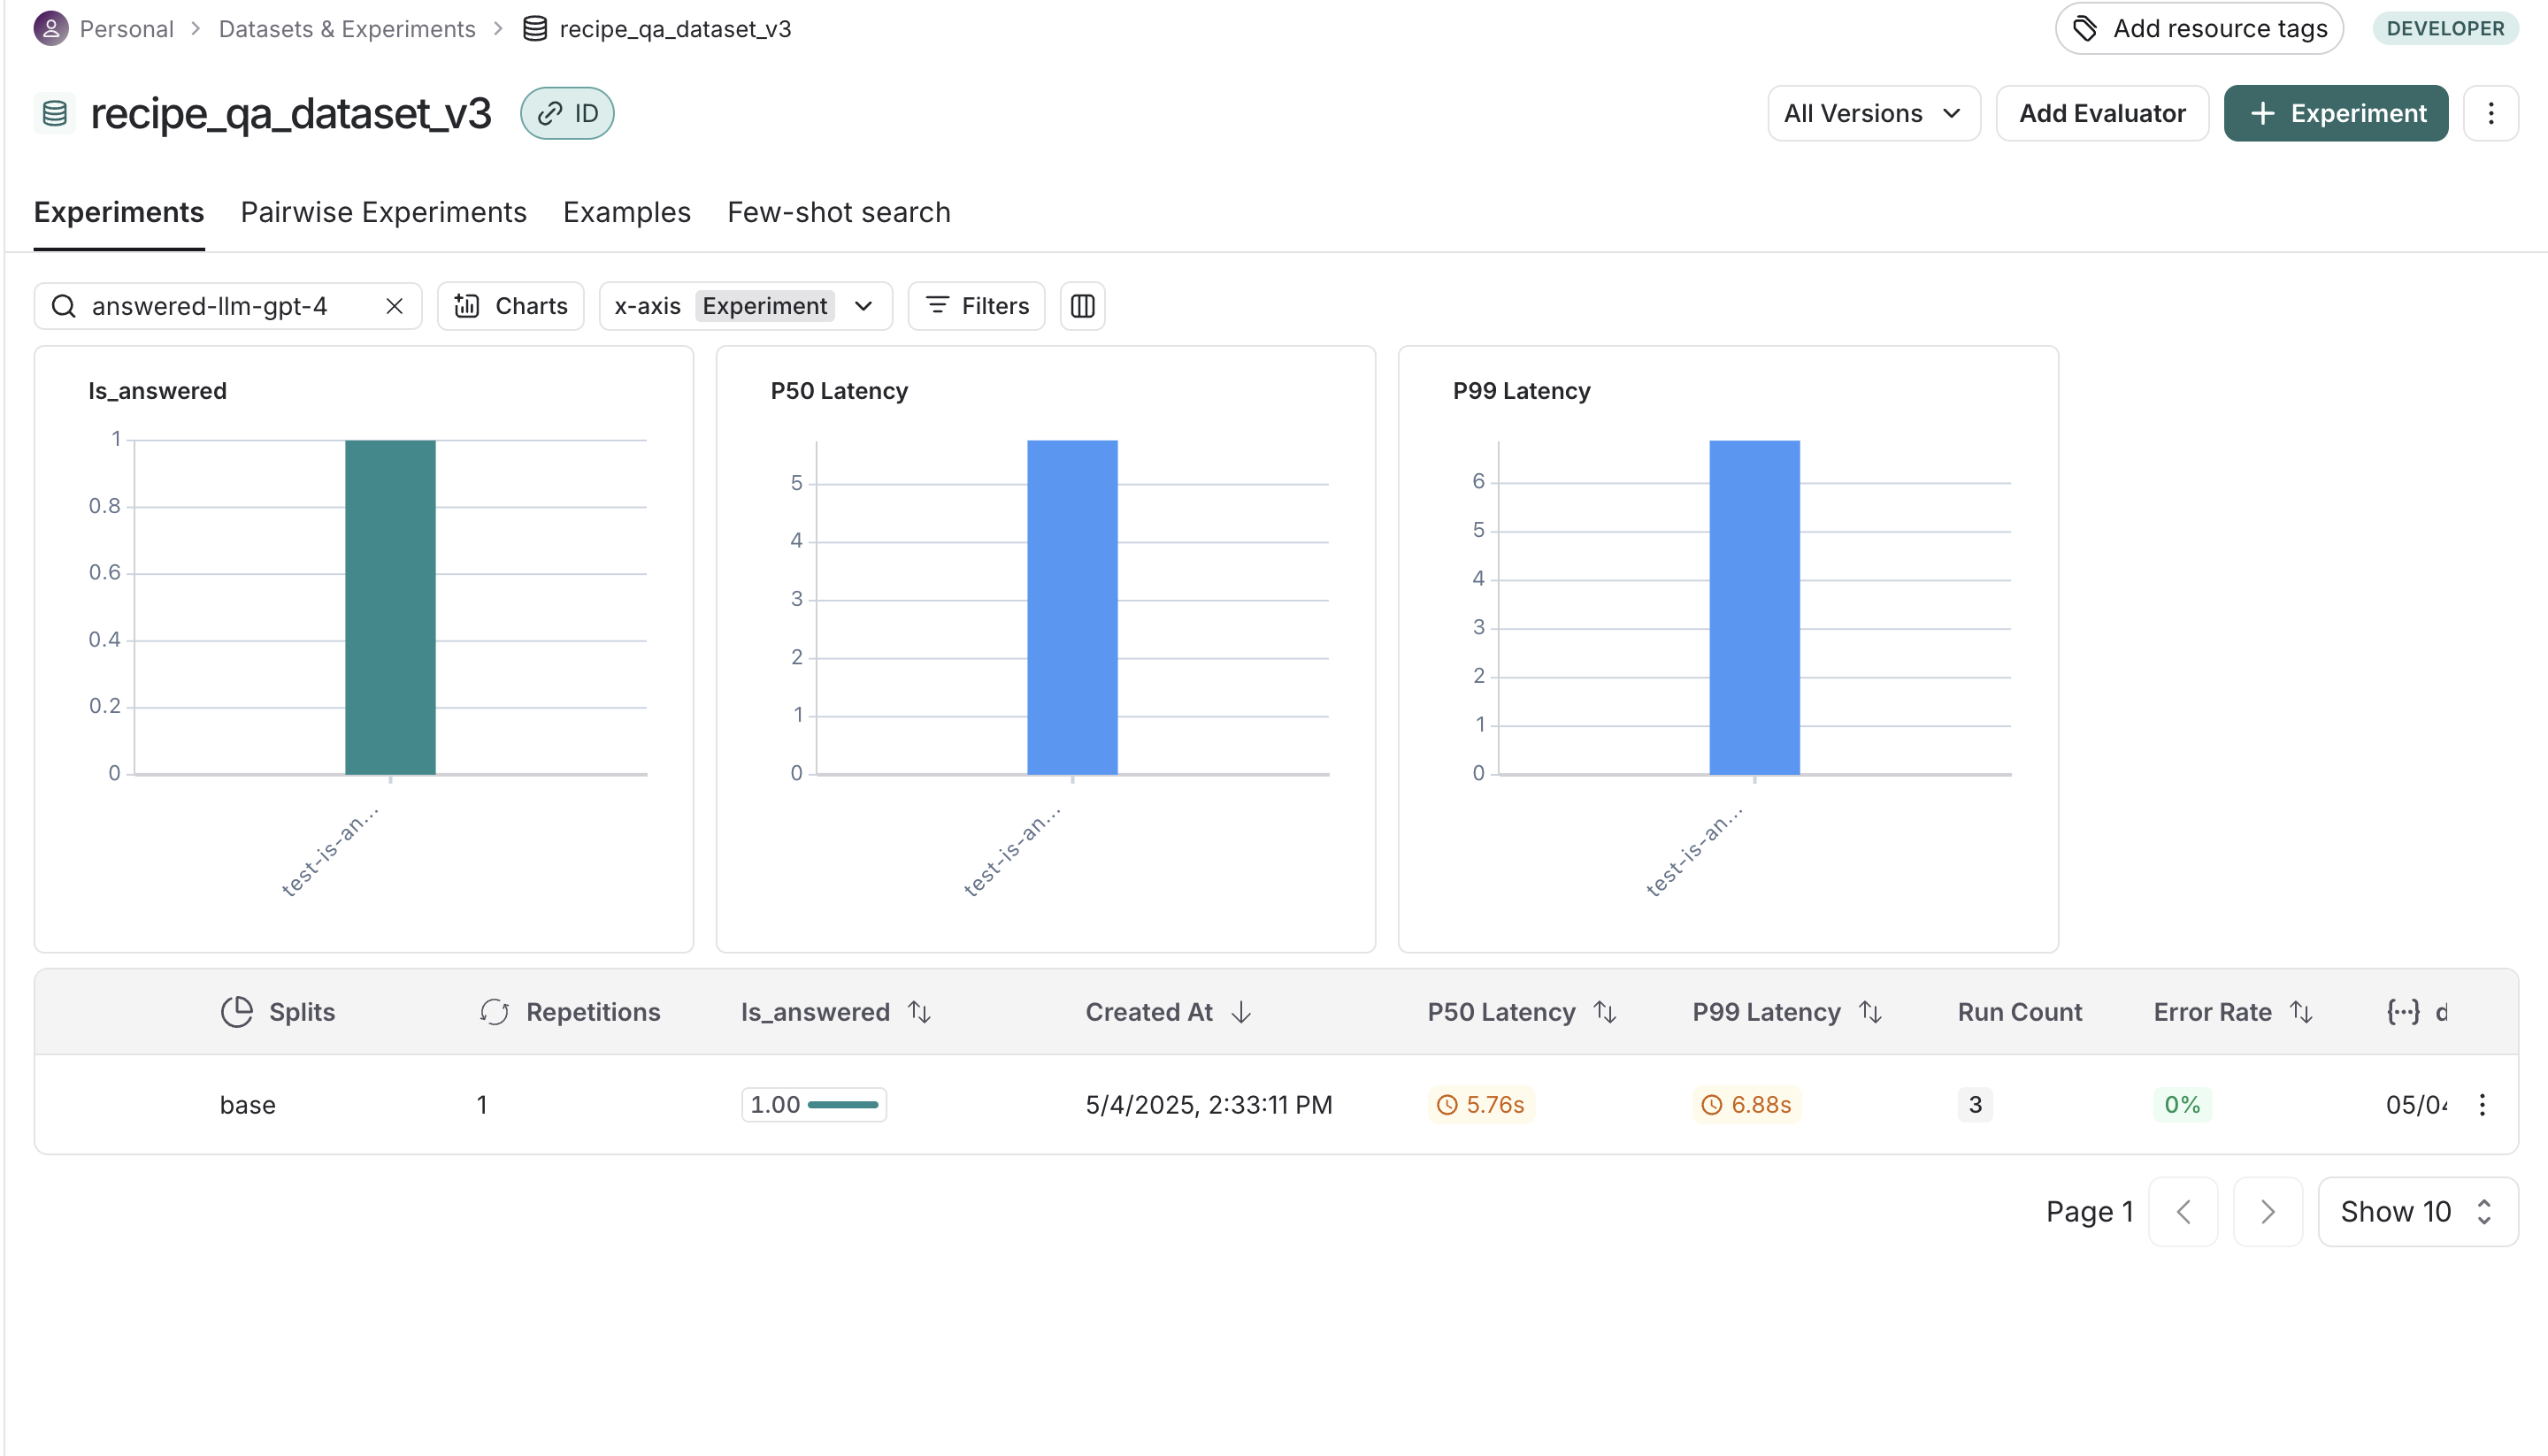

In [145]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7, openai_api_key=os.getenv("OPENAI_API_KEY"))

def is_answered(run: Run, example: Example) -> dict:
    # Get outputs
    student_answer = run.outputs.get("answer")

    # Check if the student_answer is empty
    if not student_answer:
        return {"key": "is_answered", "score": 0}

    # Use LLM to verify the answer quality
    prompt = f"""You're evaluating whether the following answer is a meaningful attempt or not.

    Question: {example.inputs.get("question")}
    Answer: {student_answer}

    Does this answer appear to be a real attempt at answering the question? Reply with "yes" or "no".
    """

    response = llm([HumanMessage(content=prompt)]).content.lower().strip()

    if "yes" in response:
        return {"key": "is_answered", "score": 1}
    else:
        return {"key": "is_answered", "score": 0}
    

qa_evalulator = [is_answered]


dataset_name = "recipe_qa_dataset_v3"

experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evalulator,  # Pass as a list
    experiment_prefix="test-eval-is-answered-llm-gpt-3.5-turbo",
    # Any experiment metadata can be specified here
    metadata={
        "variant": "context into gpt-3.5-turbo",
  
    }
)

View the evaluation results for experiment: 'test-eval-is-answered-llm-gpt-3.5-turbo-e097ff71' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=8d3291b0-3c4a-447c-a2ea-5c1d816c3ce2




3it [00:21,  7.20s/it]


![Screenshot 1446-11-06 at 23.57.51.png](<attachment:Screenshot 1446-11-06 at 23.57.51.png>)

![Screenshot 1446-11-06 at 23.59.22.png](<attachment:Screenshot 1446-11-06 at 23.59.22.png>)
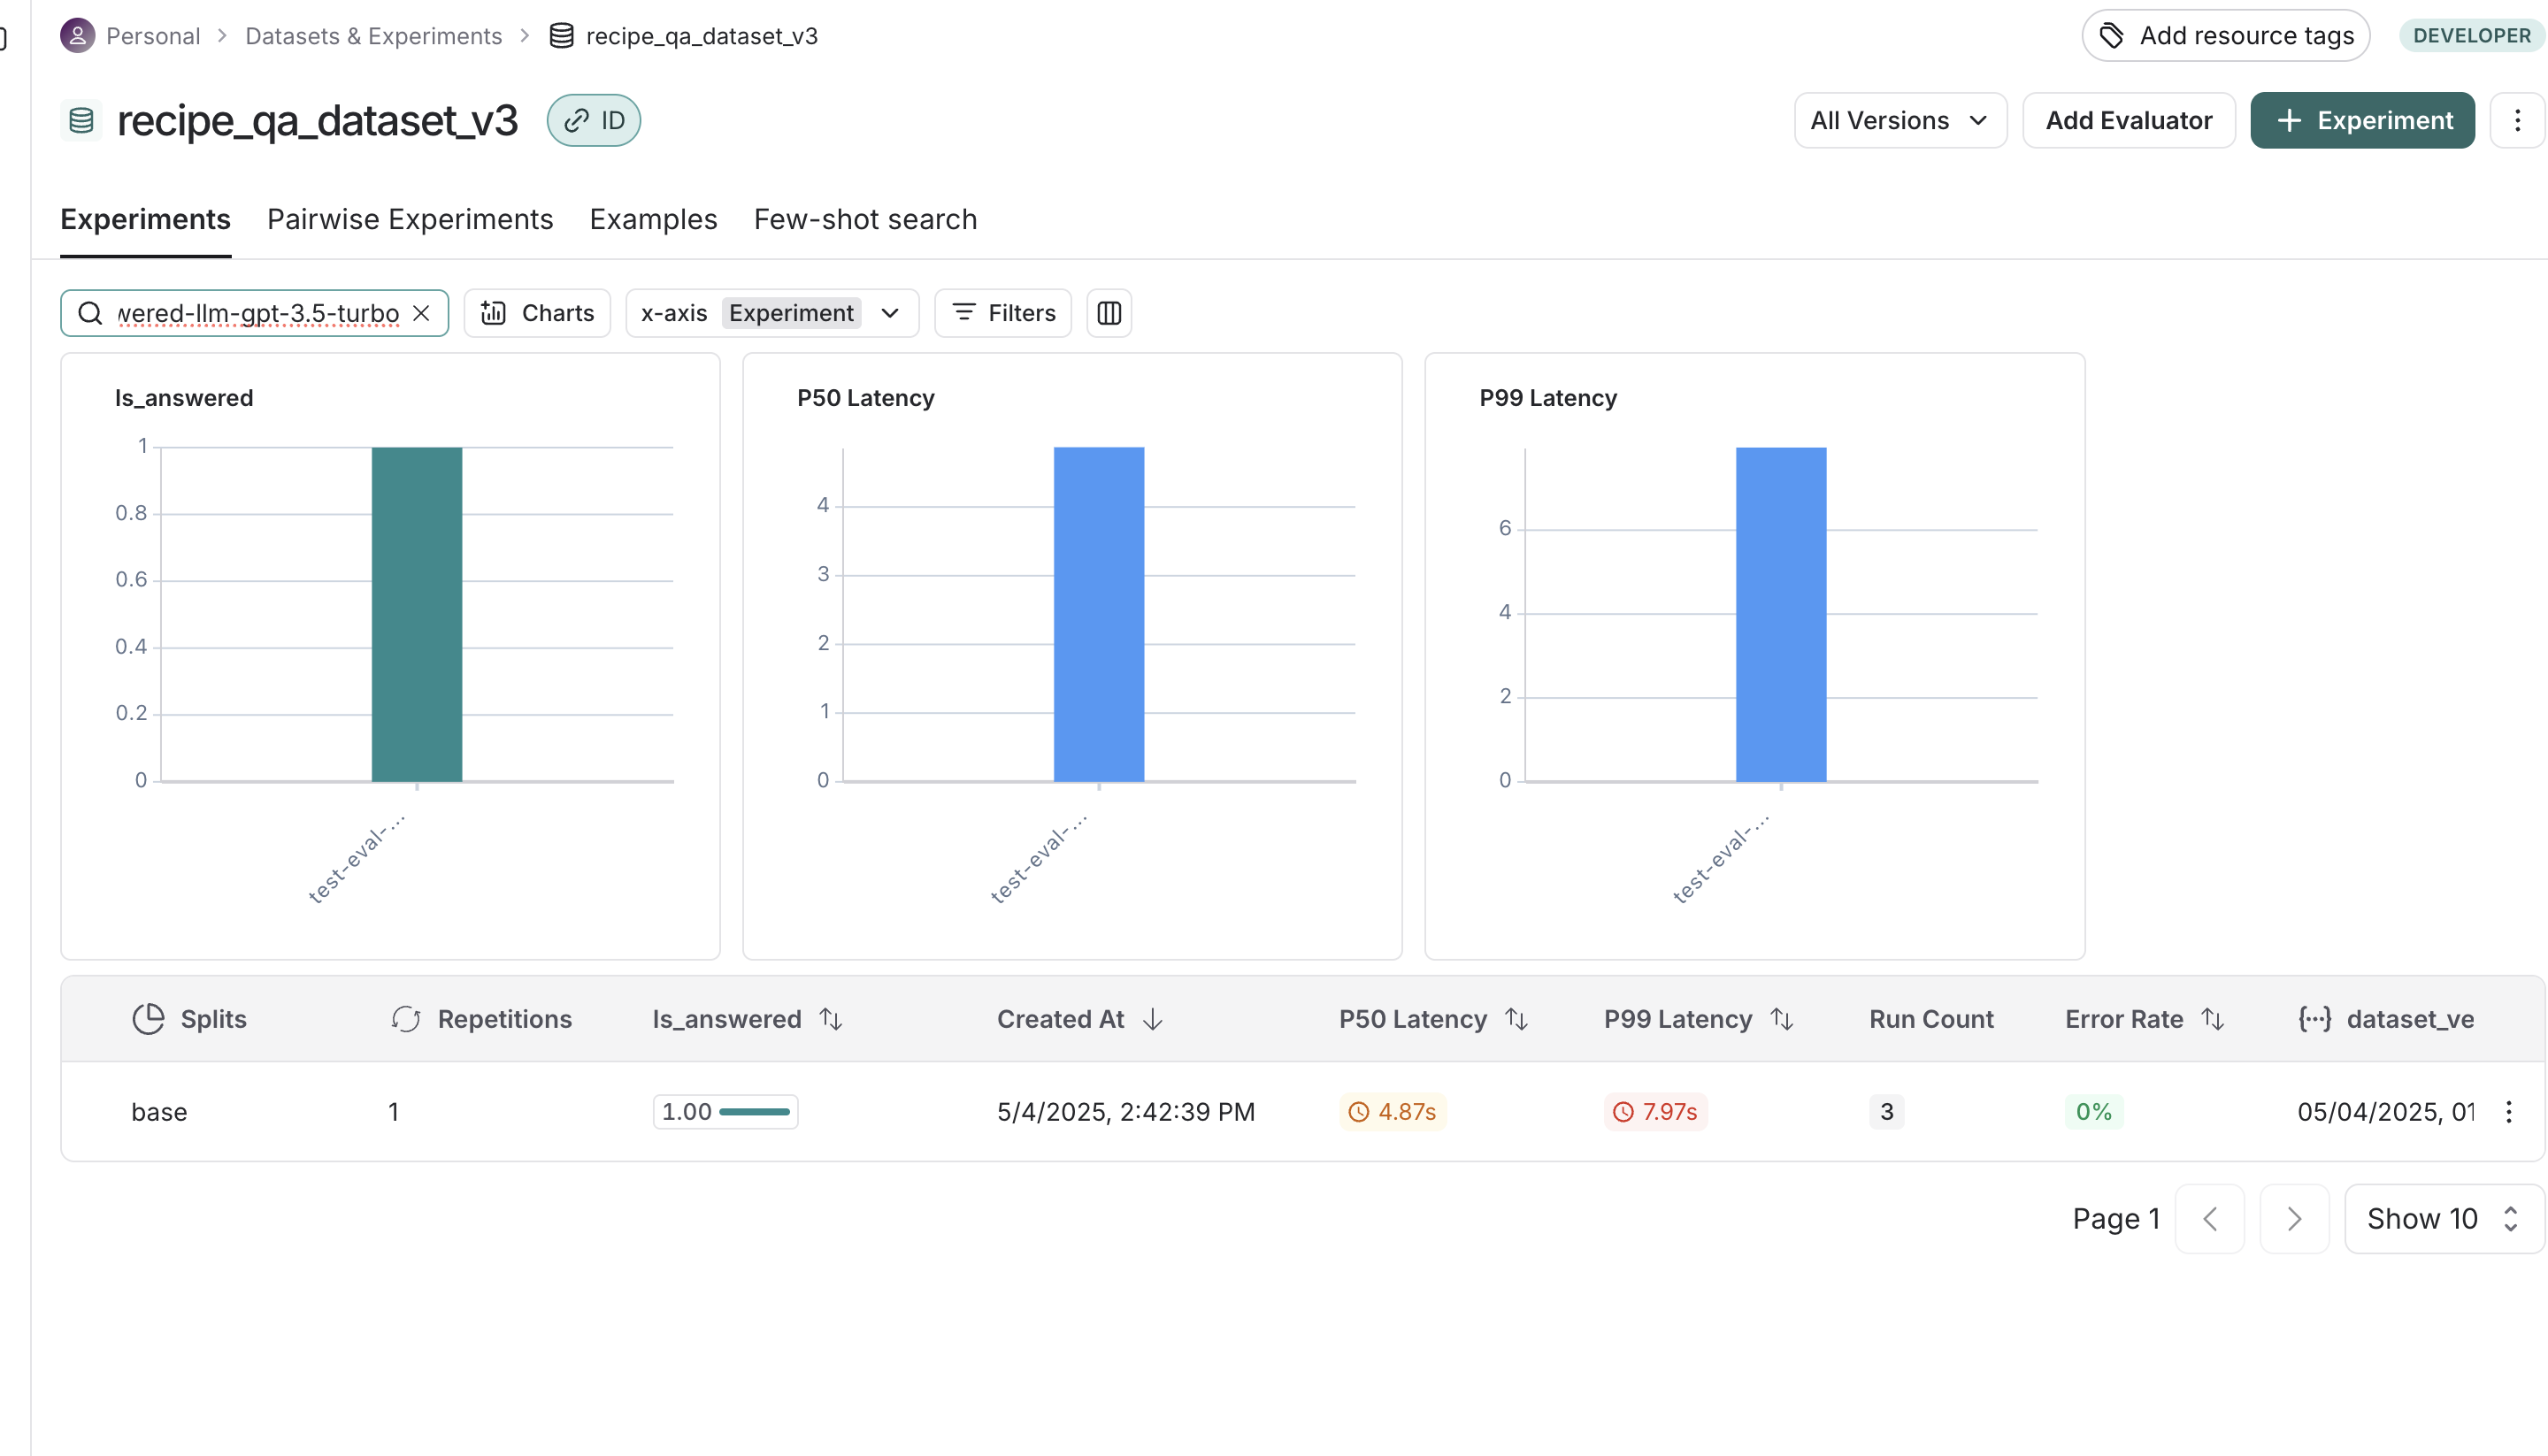
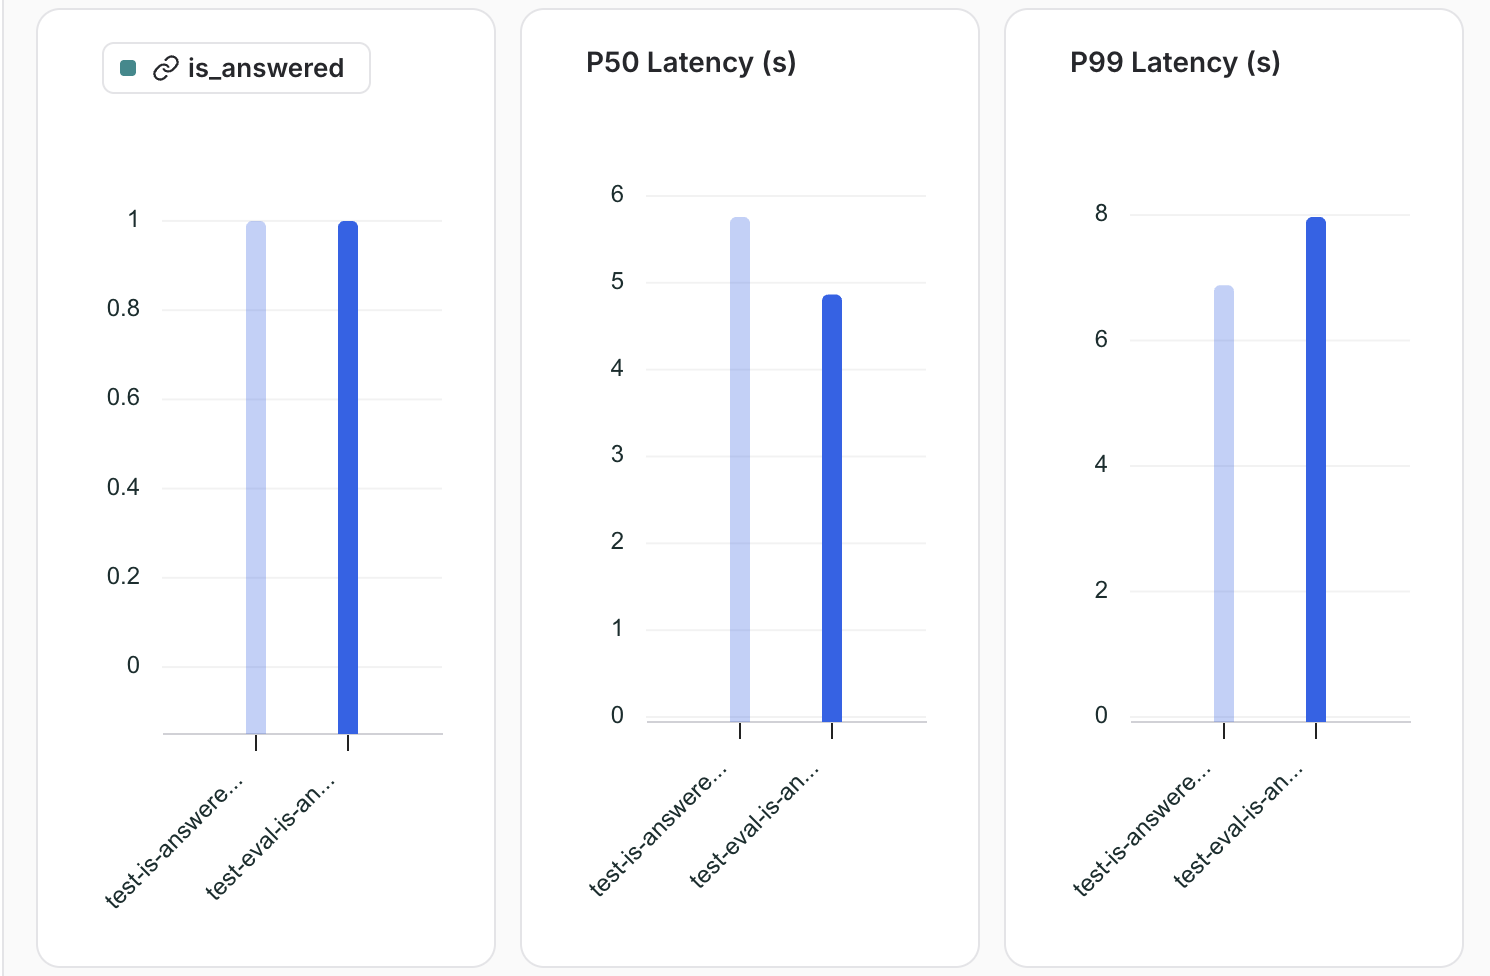

In [146]:
from langsmith.schemas import Run, Example
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
import json

# Initialize the LLM
llm = ChatOpenAI(model_name="gpt-4", temperature=0)

def answer_correctness(run: Run, example: Example) -> dict:
    student_answer = run.outputs.get("answer")
    correct_answer = example.outputs.get("answer")  # ground truth
    question = example.inputs.get("question")

    if not student_answer:
        return {"key": "answer_correctness", "score": 0, "comment": "No answer provided."}

    # Grading rubric as system prompt
    system_prompt = """You are a teacher grading a quiz.

    You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER.

    Here is the grade criteria to follow:
    (1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer.
    (2) Ensure that the student answer does not contain any conflicting statements.
    (3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the ground truth answer.

    Score:
    A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score.
    A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

    Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

    Avoid simply stating the correct answer at the outset.

    Return your response in JSON with:
    - score: 1 or 0
    - comment: your explanation
    """

    user_prompt = f"""
    QUESTION: {question}

    GROUND TRUTH ANSWER: {correct_answer}

    STUDENT ANSWER: {student_answer}
    """

    response = llm([
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]).content.strip()
    result = json.loads(response)
    return {
            "key": "answer_correctness",
            "score": result.get("score", 0),
            "comment": result.get("comment", "LLM did not provide a comment.")
        }

qa_evalulator = [answer_correctness]


dataset_name = "recipe_qa_dataset_v3"

experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evalulator,  # Pass as a list
    experiment_prefix="correctness-eval-gpt-4",
    # Any experiment metadata can be specified here
    metadata={
        "variant": "direct question answering with gpt-4",
  
    }
)


View the evaluation results for experiment: 'correctness-eval-gpt-4-f9f79a90' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=381c311e-cb2b-4752-a367-ebcde747262e




3it [00:27,  9.08s/it]


## CorrectnessGrade

In [7]:
from langchain_openai import ChatOpenAI
from langsmith.evaluation import evaluate
from typing_extensions import Annotated, TypedDict
from langsmith.schemas import Run, Example

# Ensure you're using ONLY the ChatOpenAI import from langchain_openai, not from langchain.chat_models
# Removed: from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage

from langsmith.schemas import Run, Example

class CorrectnessGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    correct: Annotated[bool, ..., "True if the answer is correct, False otherwise."]


correctness_instructions = """You are a teacher grading a quiz.

        You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER.

        Here is the grade criteria to follow:
        (1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer. 
        (2) Ensure that the student answer does not contain any conflicting statements.
        (3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.

        Correctness:
        A correctness value of True means that the student's answer meets all of the criteria.
        A correctness value of False means that the student's answer does not meet all of the criteria.

        Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

        Avoid simply stating the correct answer at the outset."""



grader_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0).with_structured_output(CorrectnessGrade, method="json_schema", strict=True)


def accuracy(inputs: dict, outputs: dict, reference_outputs: dict) -> dict:
    """An evaluator for factual correctness of student answers"""
    prompt = f"""\
QUESTION: {inputs['question']}
GROUND TRUTH ANSWER: {reference_outputs['answer']}
STUDENT ANSWER: {outputs['answer']}"""

    grade = grader_llm.invoke([
        {"role": "system", "content": correctness_instructions},
        {"role": "user", "content": prompt}
    ])
    
    return {
        "key": "answer_correctness",
        "score": 1 if grade["correct"] else 0,
        "comment": grade["explanation"]
    }


qa_evaluator = [accuracy]

experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evaluator,  # Pass as a list
    experiment_prefix="correctness-eval-gpt-3.5-turbo",
    # Any experiment metadata can be specified here
    metadata={
        "variant": "direct question answering with gpt-3.5-turbo",
  
    }
)

/Users/lama/Desktop/ChefBot/venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


View the evaluation results for experiment: 'correctness-eval-gpt-3.5-turbo-9d4684a4' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=58c0e33a-1b8c-478d-97ef-a0162859c494




3it [00:32, 10.79s/it]


![Screenshot 1446-11-07 at 00.08.06.png](<attachment:Screenshot 1446-11-07 at 00.08.06.png>)
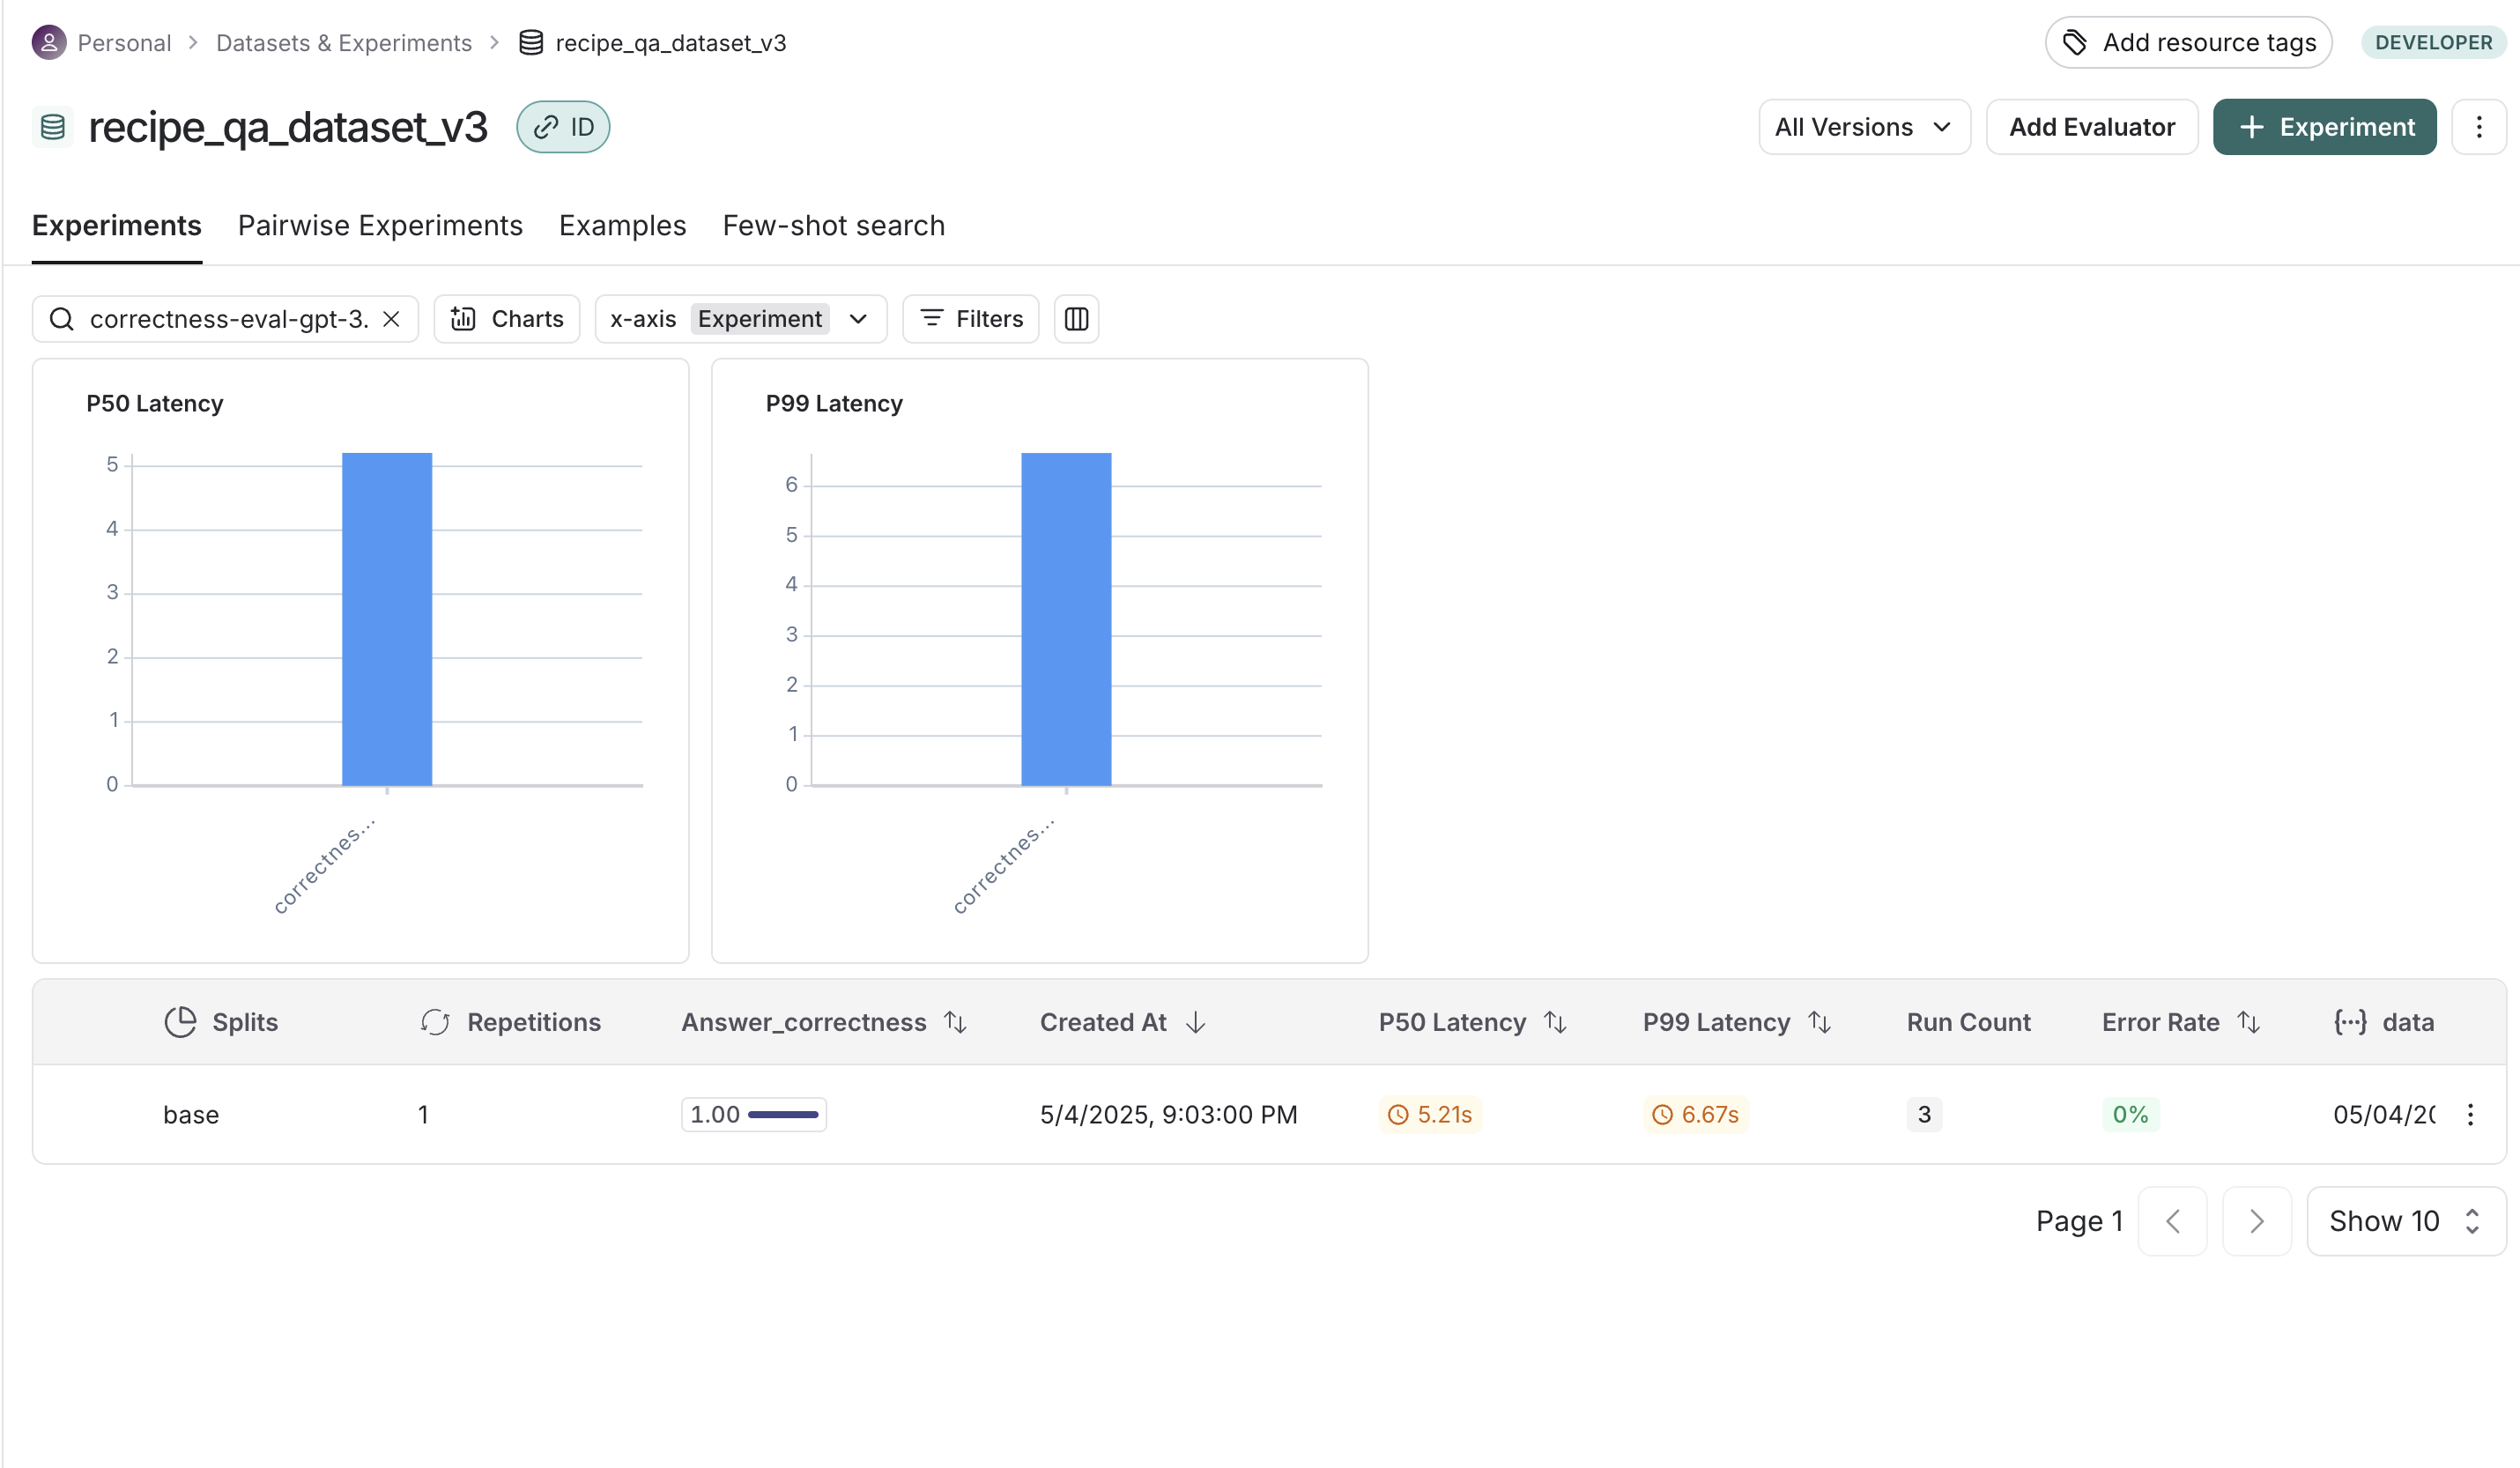

## RelevanceGrade

In [8]:
# Grade output schema
class RelevanceGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    relevant: Annotated[bool, ..., "Provide the score on whether the answer addresses the question"]



# Grade prompt
relevance_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Relevance:
A relevance value of True means that the student's answer meets all of the criteria.
A relevance value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader LLM
relevance_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0).with_structured_output(
    RelevanceGrade, method="json_schema", strict=True
)

# LangSmith-compatible evaluator function
def relevance(inputs: dict, outputs: dict):
    try:
        prompt = f"""QUESTION: {inputs['question']}
            STUDENT ANSWER: {outputs['answer']}"""

        grade = relevance_llm.invoke([
            {"role": "system", "content": relevance_instructions},
            {"role": "user", "content": prompt}
        ])
        return {
            "key": "relevance",
            "score": 1 if grade["relevant"] else 0,
            "comment": grade["explanation"]
        }
    except KeyError as e:
        return {"key": "relevance", "score": 0, "comment": f"Missing field: {e}"}


# Evaluate the model
qa_evaluator = [accuracy, relevance]

experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evaluator,
    experiment_prefix="correctness-relevance-eval-gpt-3.5-turbo",
    metadata={
        "variant": "gpt-3.5-turbo evaluation of factuality and relevance"
    }
)

/Users/lama/Desktop/ChefBot/venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


View the evaluation results for experiment: 'correctness-relevance-eval-gpt-3.5-turbo-aa50fddf' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=2cbc8d00-1039-41d2-bf9e-4d965d7bfa91




3it [00:27,  9.05s/it]


![alt text](<Screenshot 1446-11-07 at 00.18.03.png>)
![Screenshot 1446-11-07 at 00.16.58.png](<attachment:Screenshot 1446-11-07 at 00.16.58.png>)


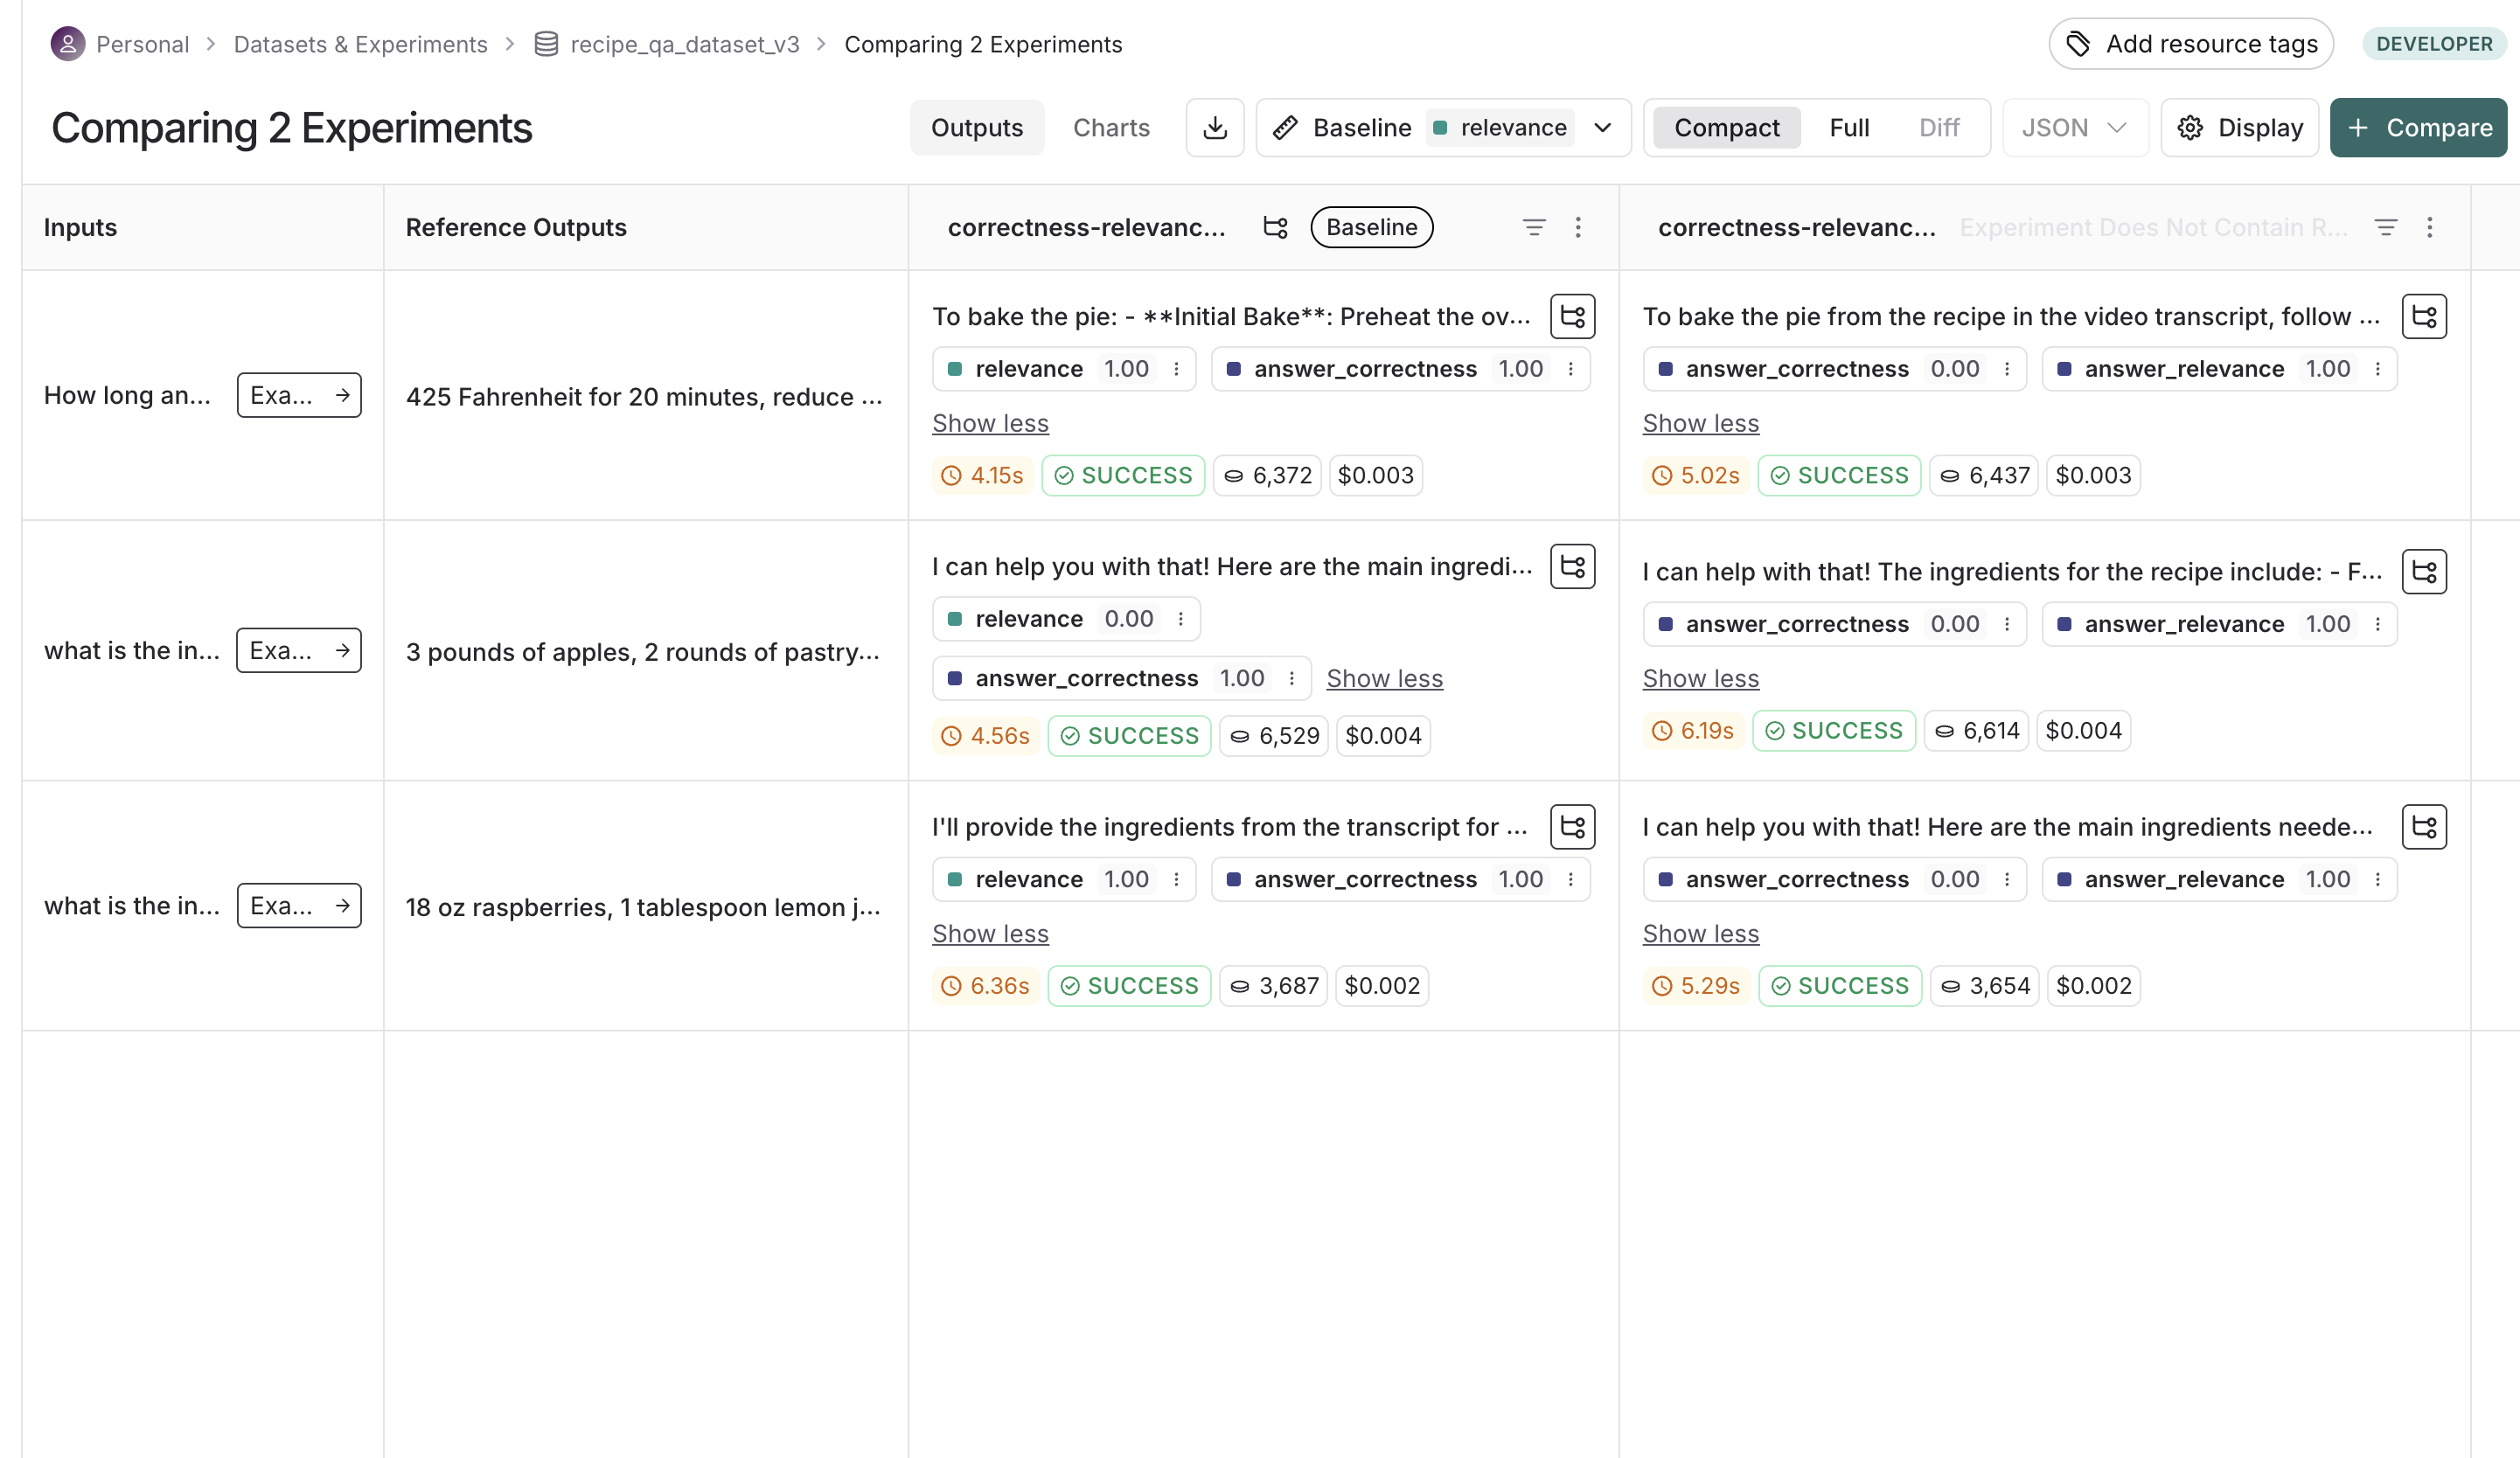

## FaithfulnessGrade

In [11]:
class FaithfulnessGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[int, ..., "1 = summary is faithful (no hallucinations), 0 = unfaithful (hallucinations present)"]


faithfulness_llm = ChatOpenAI(
    model="gpt-3.5-turbo", temperature=0
).with_structured_output(FaithfulnessGrade, method="json_schema", strict=True)

faithfulness_instructions = """
        You are grading text summaries of larger source documents focused on faithfulness and detection of any hallucinations.

        Ensure that the Assistant's Summary meets the following criteria: 
        (1) it does not contain information outside the score of the source documents
        (2) the summary should be fully grounded in and based upon the source documents 

        Score:
        A score of 1 means that the Assistant Summary meets the criteria. This is the highest (best) score. 
        A score of 0 means that the Assistant Summary does not the criteria. This is the lowest possible score you can give.

        Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 
"""
def hallucination(inputs: dict, outputs: dict):
    try:
        prompt = f"""SOURCE DOCUMENTS: {inputs['source_documents']}
ASSISTANT SUMMARY: {outputs['answer']}"""

        grade = faithfulness_llm.invoke([
            {"role": "system", "content": faithfulness_instructions},
            {"role": "user", "content": prompt}
        ])
        return {
            "key": "hallucination",
            "score": 1 if grade["faithful"] else 0,
            "comment": grade["explanation"]
        }
    except KeyError as e:
        return {"key": "hallucination", "score": 0, "comment": f"Missing field: {e}"}
    

qa_evaluator = [hallucination]

experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evaluator,
    experiment_prefix="summary-faithfulness-eval-gpt-3.5-turbo",
    metadata={"variant": "faithfulness evaluation"}
)

/Users/lama/Desktop/ChefBot/venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


View the evaluation results for experiment: 'summary-faithfulness-eval-gpt-3.5-turbo-15e67067' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=33955aae-24ca-44e0-bfc3-eace79aa5240




3it [00:18,  6.05s/it]


![Screenshot 1446-11-07 at 00.23.18.png](<attachment:Screenshot 1446-11-07 at 00.23.18.png>)
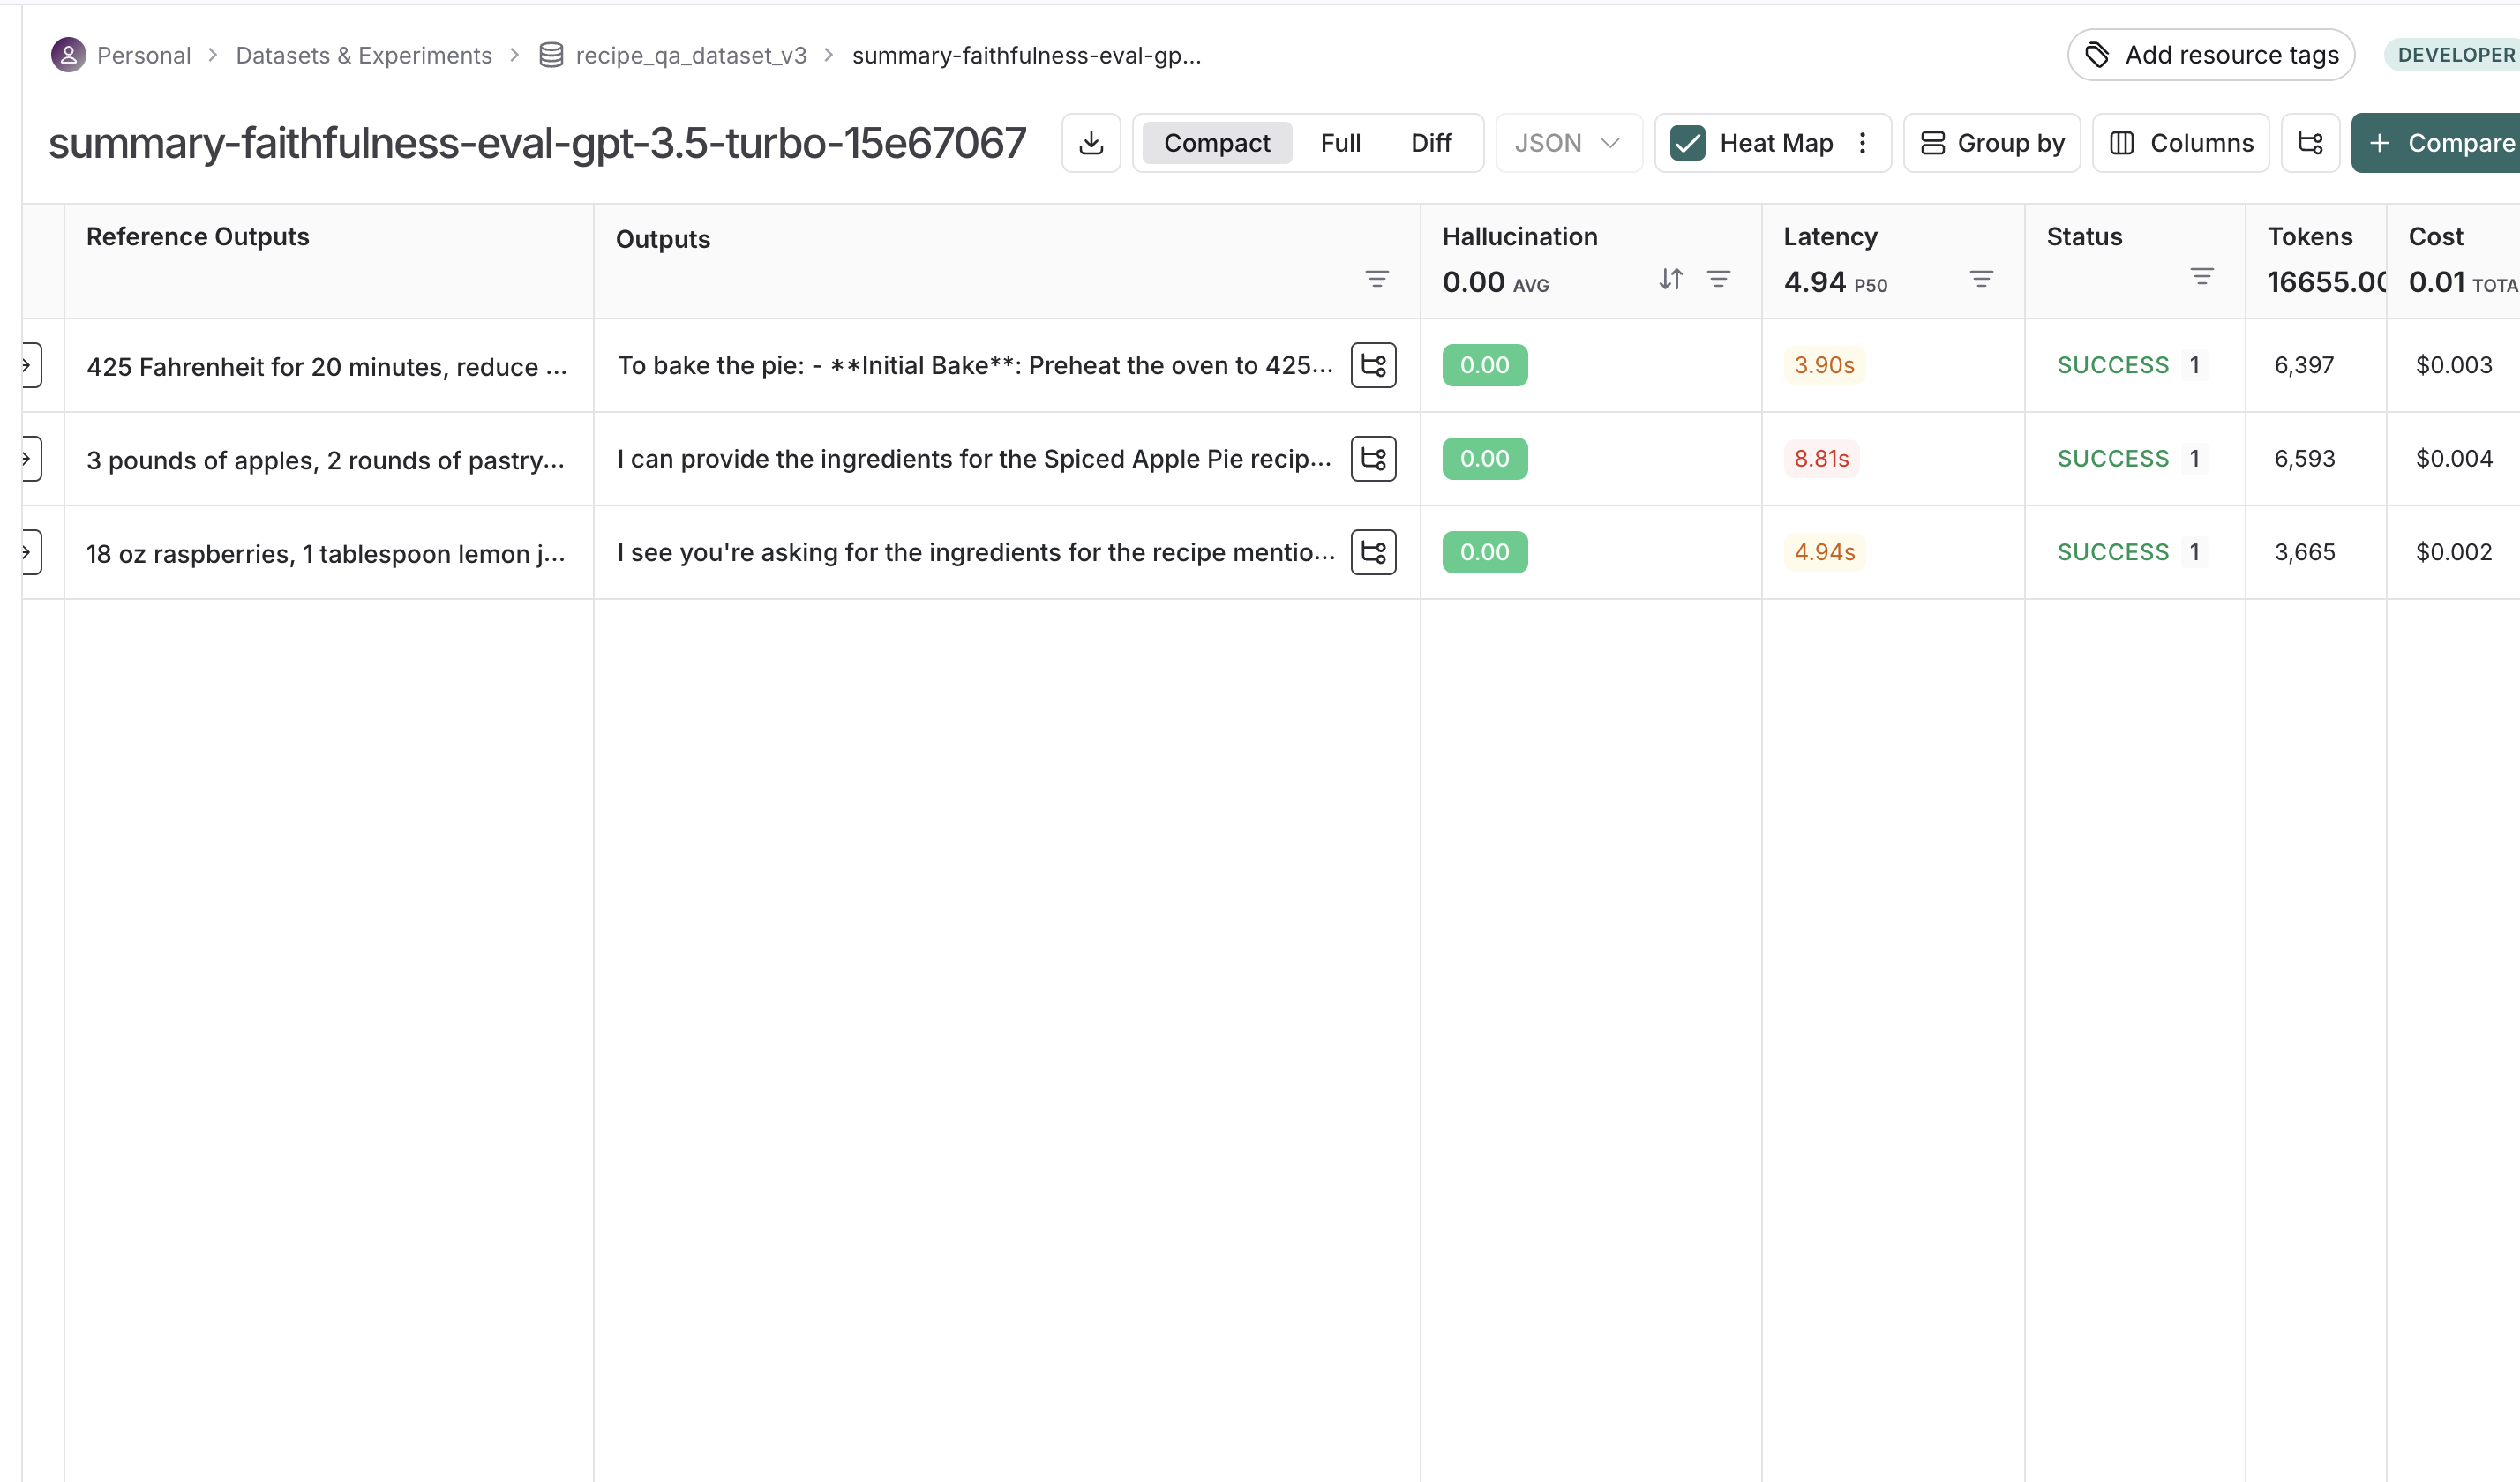

In [10]:
# Grade output schema for hallucination
class HallucinationGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    hallucinated: Annotated[bool, ..., "True means the answer contains factual hallucinations"]

hallucination_instructions = """You are a fact-checking teacher grading a quiz.

    You will be given a QUESTION and a STUDENT ANSWER.

    Grade Criteria:
    (1) Verify that the answer is factually correct and based on known or logically inferred facts.
    (2) Determine if the answer includes any made-up or fabricated information (hallucinations).

    Hallucination:
    - A value of True means that the student's answer includes fabricated or unverifiable claims.
    - A value of False means that the answer is factually accurate and grounded.

    Explain your reasoning clearly and step-by-step before giving a final judgment."""

# Grader LLM
hallucination_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0).with_structured_output(
    HallucinationGrade, method="json_schema", strict=True
)

def hallucination(inputs: dict, outputs: dict):
    try:
        prompt = f"""QUESTION: {inputs['question']}
         STUDENT ANSWER: {outputs['answer']}"""

        grade = hallucination_llm.invoke([
            {"role": "system", "content": hallucination_instructions},
            {"role": "user", "content": prompt}
        ])
        return {
            "key": "hallucination",
            "score": 1 if grade["hallucinated"] else 0,
            "comment": grade["explanation"]
        }
    except KeyError as e:
        return {"key": "hallucination", "score": 0, "comment": f"Missing field: {e}"}


# Evaluate the model
qa_evaluator = [hallucination]
experiment_results = evaluate(
    target,
    data=dataset_name,
    evaluators=qa_evaluator,
    experiment_prefix="hallucination-eval-gpt-3.5-turbo",
    metadata={
        "variant": "gpt-3.5-turbo evaluation of hallucination"
    }
)



/Users/lama/Desktop/ChefBot/venv/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


View the evaluation results for experiment: 'hallucination-eval-gpt-3.5-turbo-5a85d86e' at:
https://smith.langchain.com/o/c1bc43a6-f6e3-5196-b741-e19b49468804/datasets/3e721e03-e315-482d-8897-4629ac353280/compare?selectedSessions=2ddf8a0f-1bd2-416e-b575-f1c3f974b38e




3it [00:30, 10.02s/it]


![Screenshot 1446-11-07 at 00.24.45.png](<attachment:Screenshot 1446-11-07 at 00.24.45.png>)
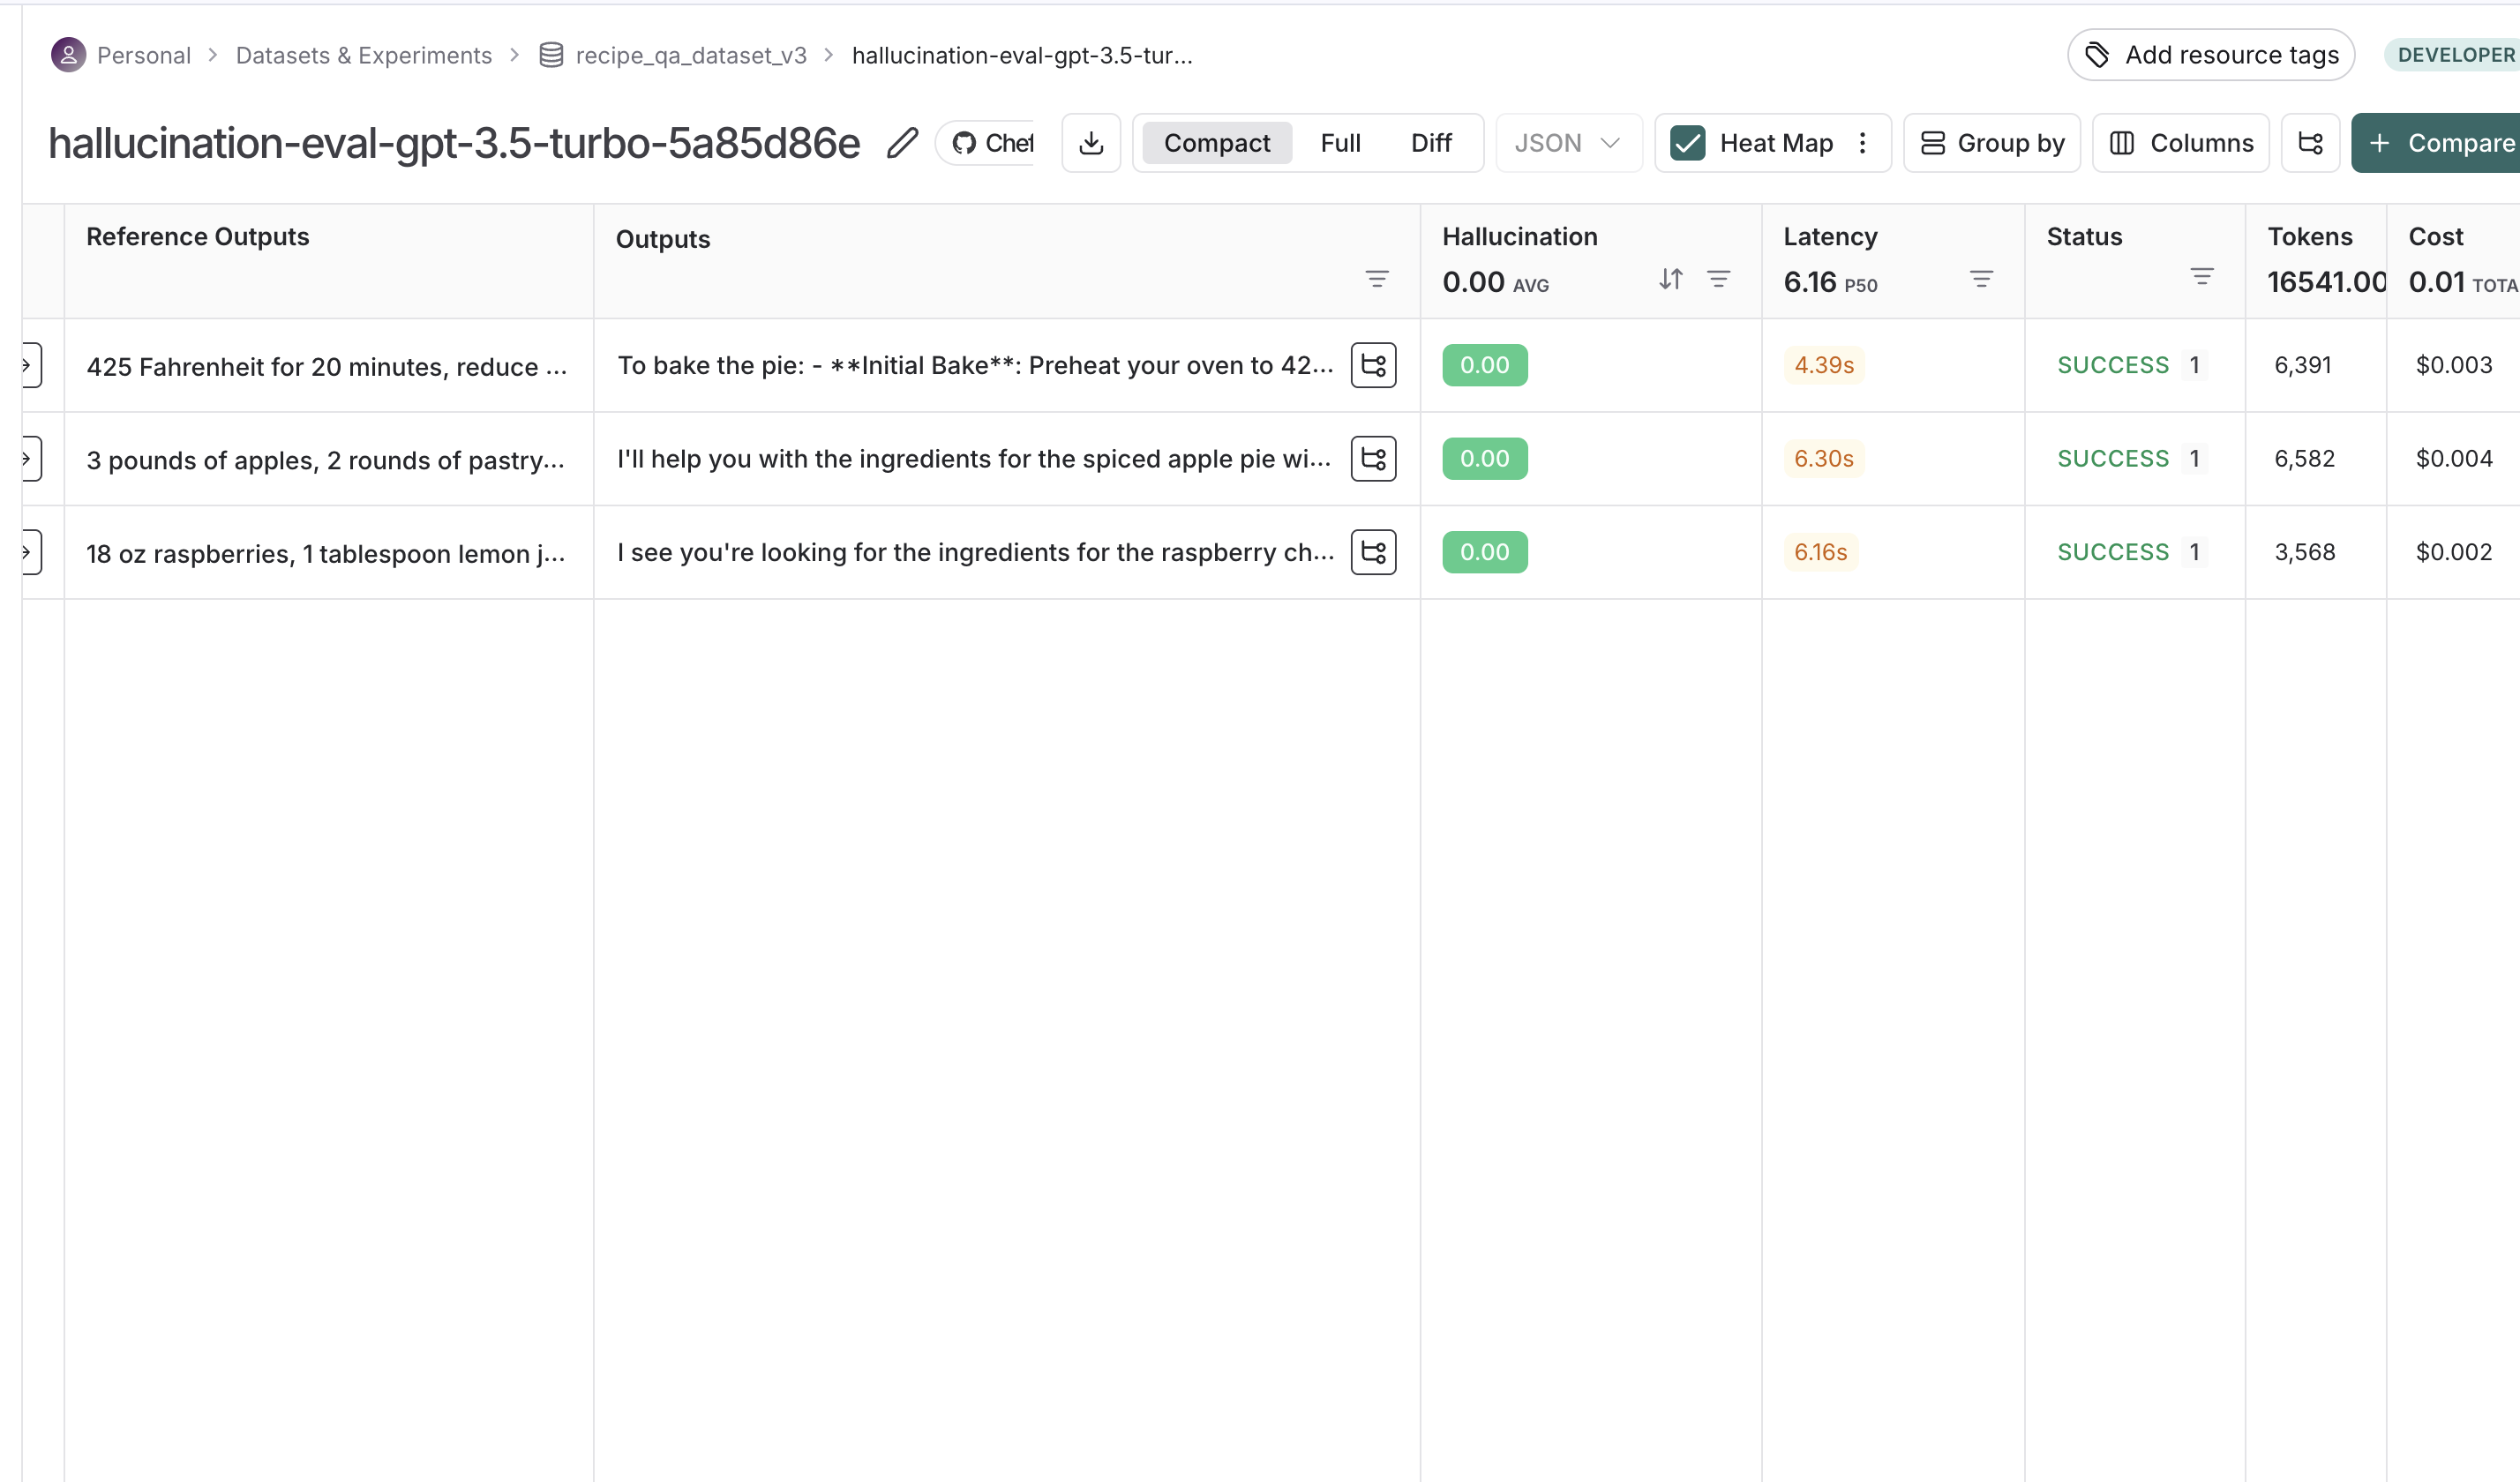